# WEB APIs and NLP Modelling: Reddit Post Classification Project

### Importing neccesary libraries

In [1]:
import praw
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC


pd.options.display.max_colwidth = 400

### Reading in Data

In [2]:
df = pd.read_csv('Data')

In [3]:
df = df.drop_duplicates()
df.shape

(9189, 6)

In [4]:
df = df.drop(['Unnamed: 0.1','Unnamed: 0'],axis = 1)

In [5]:
df.isnull().sum()

time            0
title           0
text         3774
subreddit       0
dtype: int64

### Preliminary EDA

In [6]:
df['subreddit'].value_counts(normalize=True)

CryptoCurrency    0.591795
wallstreetbets    0.408205
Name: subreddit, dtype: float64

In [7]:
df.describe()

,time
count,9.189000e+03
mean,1.650058e+09
std,4.359377e+07
min,1.388626e+09
25%,1.624551e+09
50%,1.660979e+09
75%,1.686353e+09
max,1.687180e+09


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9189 entries, 0 to 9188
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       9189 non-null   float64
 1   title      9189 non-null   object 
 2   text       5415 non-null   object 
 3   subreddit  9189 non-null   object 
dtypes: float64(1), object(3)
memory usage: 358.9+ KB


In [9]:
df.head()

,time,title,text,subreddit
0,1.686874e+09,apparently cramer saids we aint buying tech?,&#x200B;\n\n[he truly smokes the greatest stuff. ](https://preview.redd.it/bzssf7h6t96b1.png?width=1103&format=png&auto=webp&v=enabled&s=5f54cfa651987caac7a04191f6caea39ce3bf009),wallstreetbets
1,1.686873e+09,This is actually a new bull market,"A lot of people here will still insist that this recent rally is a big bear trap in the making. But I think we will actually get new All Time High's on the S and P by early 2024. The bear's main thesis is that we are heading to a recession and that earnings will collapse as a result, meaning current valuations are too high. \n\n\nI used to be in the bear camp but the economy has proven to be...",wallstreetbets
2,1.686873e+09,"This isn’t a bubble it’s a revolution, like the industrial revolution, just on a grand scale.",The Dot Com bubble burst because the internet and the infrastructure were not ready and capable of supporting the companies going public at a rapid pace. During the Dot Com era dial up was the primary internet. Most homes didn’t have a computer or cell phones and Robinhood didn’t exist. Today we have fiber optic internet. More information on the internet than a person can read in one lifetime....,wallstreetbets
3,1.686873e+09,Technical Outlook on SPY Indicates Bullish Bias,"The technical outlook for SPY suggests a bullish bias. The focus is on a potential pullback to the M15 order blocks at 440.90 - 440.17 and 439.56 - 438.40. If these blocks are not reached, a bullish flip of the 442.57 - 442.40 M15 order block will be necessary. Lose the M15 blocks then look for prior day's low.\n\nThe H1 Dealing Range stands as follows:\n\n* 100%: 443.89\n* 50%: 439.41\n* 0%: ...",wallstreetbets
4,1.686871e+09,Virgin Galactic $SPCE,Virgin Galactic starts commercial flights at the end of the month. This is the first space travel company approved by FAA.\n\nNot sure of the long term health of the company but buying a few calls.,wallstreetbets


In [10]:
df.dtypes

time         float64
title         object
text          object
subreddit     object
dtype: object

### Data Cleaning

In [11]:
# Filling in all NaN values with empty strings
df['text'] = df['text'].fillna('')

In [12]:
# Combining the Title and Text columns
df['title_and_text'] = df['title']+df['text']

In [13]:
# Removing unnecessesary characters and alpha-numeirc words
def char_remover(data):
    data = data.replace('\\n','')
    data = data.replace('\n','')
    data = data.replace('&#x200B','')
    return data

df['title_and_text'] = df['title_and_text'].apply(char_remover).str.replace('[\w\d]+\d+[\w\d]+','',regex = True)

In [14]:
# Adding text lenght and title lenght columns
df['title_len'] = df.title.str.len()
df['text_len'] = df.text.str.len()

In [15]:
# Adding title and text word counts
df['title_word_count'] = df['title'].apply(lambda x: len(x.split(' ')))
df['text_word_count'] = df['text'].apply(lambda x: len(x.split(' ')))

In [16]:
# Mapping 'wallstreetbets' subreddit to 1, and 'Cryptocurrency' subbreddit to 0
df['subreddit'] = np.where(df['subreddit'] == 'wallstreetbets',1,0)

In [17]:
# Adding sentiment analysis columns for title, text, and title+text columns 

sia = SentimentIntensityAnalyzer()
def composite_sentiment(data):
    scores = sia.polarity_scores(data)["compound"]
    return scores

df["composite_sentiment_text"] = df["text"].apply(composite_sentiment)
df['composite_sentiment_title'] = df['title'].apply(composite_sentiment)
df['composite_sentiment_title_and_text'] = df['title_and_text'].apply(composite_sentiment)
df.head()

,time,title,text,subreddit,title_and_text,title_len,text_len,title_word_count,text_word_count,composite_sentiment_text,composite_sentiment_title,composite_sentiment_title_and_text
0,1.686874e+09,apparently cramer saids we aint buying tech?,&#x200B;\n\n[he truly smokes the greatest stuff. ](https://preview.redd.it/bzssf7h6t96b1.png?width=1103&format=png&auto=webp&v=enabled&s=5f54cfa651987caac7a04191f6caea39ce3bf009),1,apparently cramer saids we aint buying tech?;[he truly smokes the greatest stuff. ](https://preview.redd.it/.png?width=&format=png&auto=webp&v=enabled&s=),44,176,7,7,0.7964,0.0000,0.4860
1,1.686873e+09,This is actually a new bull market,"A lot of people here will still insist that this recent rally is a big bear trap in the making. But I think we will actually get new All Time High's on the S and P by early 2024. The bear's main thesis is that we are heading to a recession and that earnings will collapse as a result, meaning current valuations are too high. \n\n\nI used to be in the bear camp but the economy has proven to be...",1,"This is actually a new bull marketA lot of people here will still insist that this recent rally is a big bear trap in the making. But I think we will actually get new All Time High's on the S and P by early . The bear's main thesis is that we are heading to a recession and that earnings will collapse as a result, meaning current valuations are too high. I used to be in the bear camp but the ...",34,2154,7,396,-0.9250,0.0000,-0.9250
2,1.686873e+09,"This isn’t a bubble it’s a revolution, like the industrial revolution, just on a grand scale.",The Dot Com bubble burst because the internet and the infrastructure were not ready and capable of supporting the companies going public at a rapid pace. During the Dot Com era dial up was the primary internet. Most homes didn’t have a computer or cell phones and Robinhood didn’t exist. Today we have fiber optic internet. More information on the internet than a person can read in one lifetime....,1,"This isn’t a bubble it’s a revolution, like the industrial revolution, just on a grand scale.The Dot Com bubble burst because the internet and the infrastructure were not ready and capable of supporting the companies going public at a rapid pace. During the Dot Com era dial up was the primary internet. Most homes didn’t have a computer or cell phones and Robinhood didn’t exist. Today we have f...",93,2368,16,418,0.9904,0.6705,0.9888
3,1.686873e+09,Technical Outlook on SPY Indicates Bullish Bias,"The technical outlook for SPY suggests a bullish bias. The focus is on a potential pullback to the M15 order blocks at 440.90 - 440.17 and 439.56 - 438.40. If these blocks are not reached, a bullish flip of the 442.57 - 442.40 M15 order block will be necessary. Lose the M15 blocks then look for prior day's low.\n\nThe H1 Dealing Range stands as follows:\n\n* 100%: 443.89\n* 50%: 439.41\n* 0%: ...",1,"Technical Outlook on SPY Indicates Bullish BiasThe technical outlook for SPY suggests a bullish bias. The focus is on a potential pullback to the order blocks at .90 - .17 and .56 - .40. If these blocks are not reached, a bullish flip of the .57 - .40 order block will be necessary. Lose the blocks then look for prior day's low.The H1 Dealing Range stands as follows:* %: .89* 50%: .41* 0%: ....",47,1246,7,181,-0.8778,-0.1027,-0.9080
4,1.686871e+09,Virgin Galactic $SPCE,Virgin Galactic starts commercial flights at the end of the month. This is the first space travel company approved by FAA.\n\nNot sure of the long term health of the company but buying a few calls.,1,Virgin Galactic $SPCEVirgin Galactic starts commercial flights at the end of the month. This is the first space travel company approved by FAA.Not sure of the long term health of the company but buying a few calls.,21,195,3,35,0.1076,0.0000,0.3716


### Visualisations

In [69]:
#Histogram plot function used multiple times below
def hist_plot(data, column):
    plt.figure(figsize=(10, 8))
    plt.hist(data[data['subreddit'] == 1][column], bins=30, color='teal', alpha=0.5, label='/wallstreetbets')
    plt.hist(data[data['subreddit'] != 1][column], bins=30, color='magenta', alpha=0.3, label='/CryptoCurrency')
    plt.legend()
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Histogram of ' + column, fontsize=14)
    plt.tight_layout()
    plt.savefig(f'Images/{column}.png',dpi = 300)
    plt.show()
    

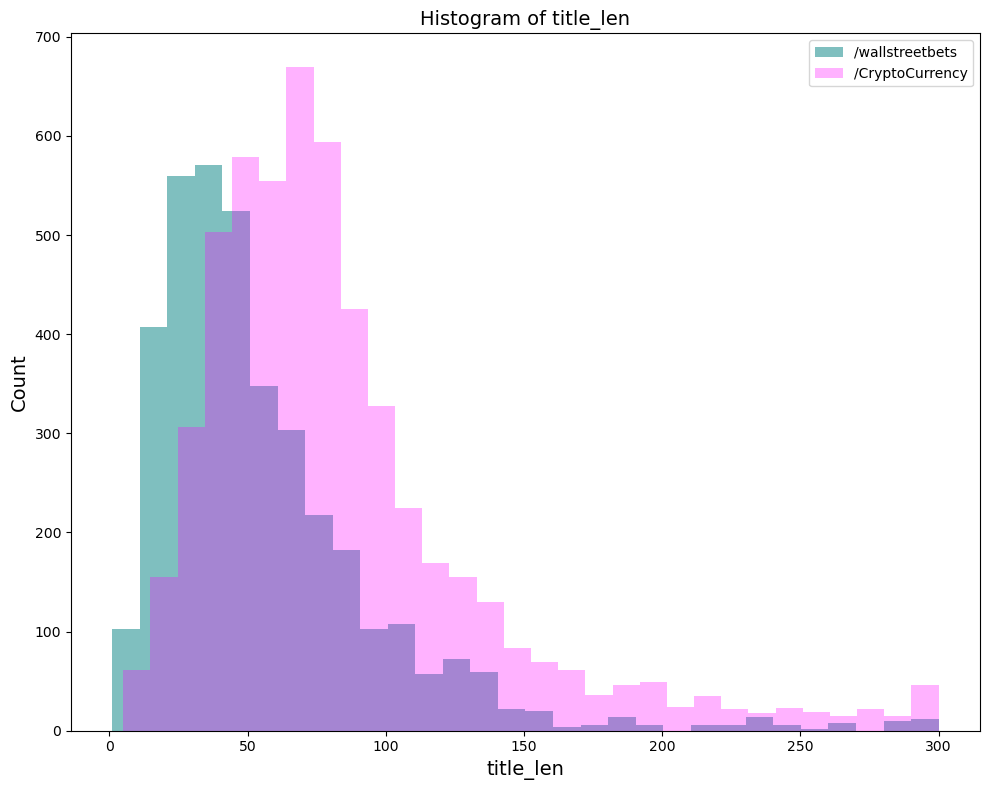

In [70]:
hist_plot(df,'title_len')

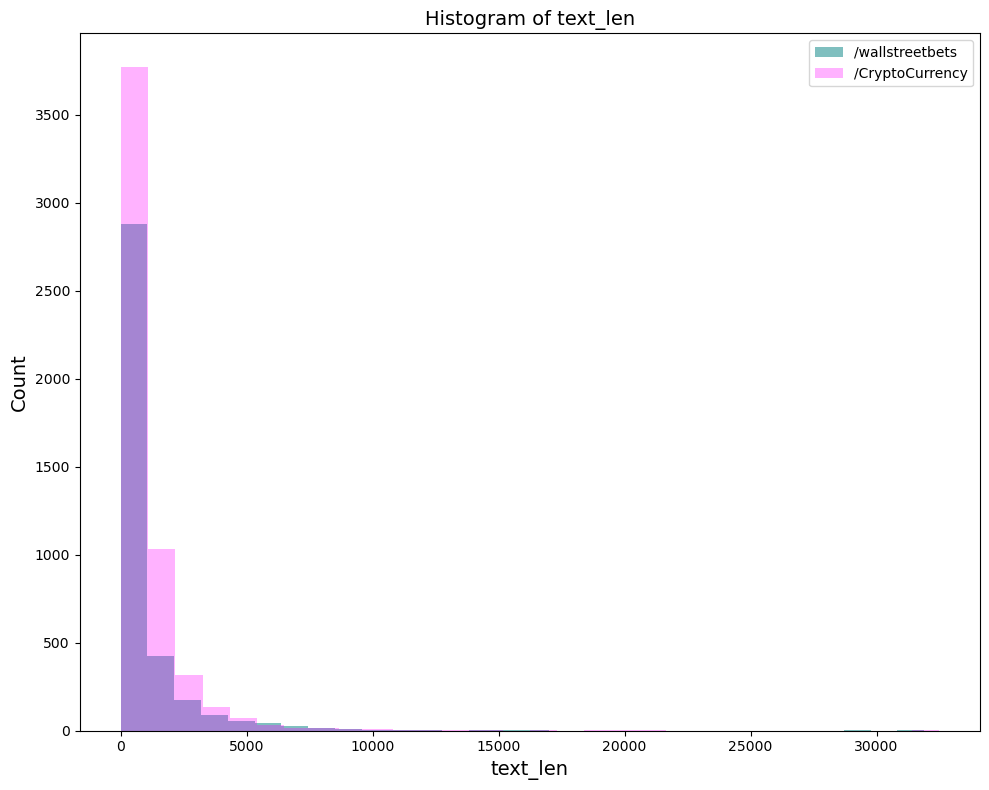

In [71]:
hist_plot(df,'text_len')

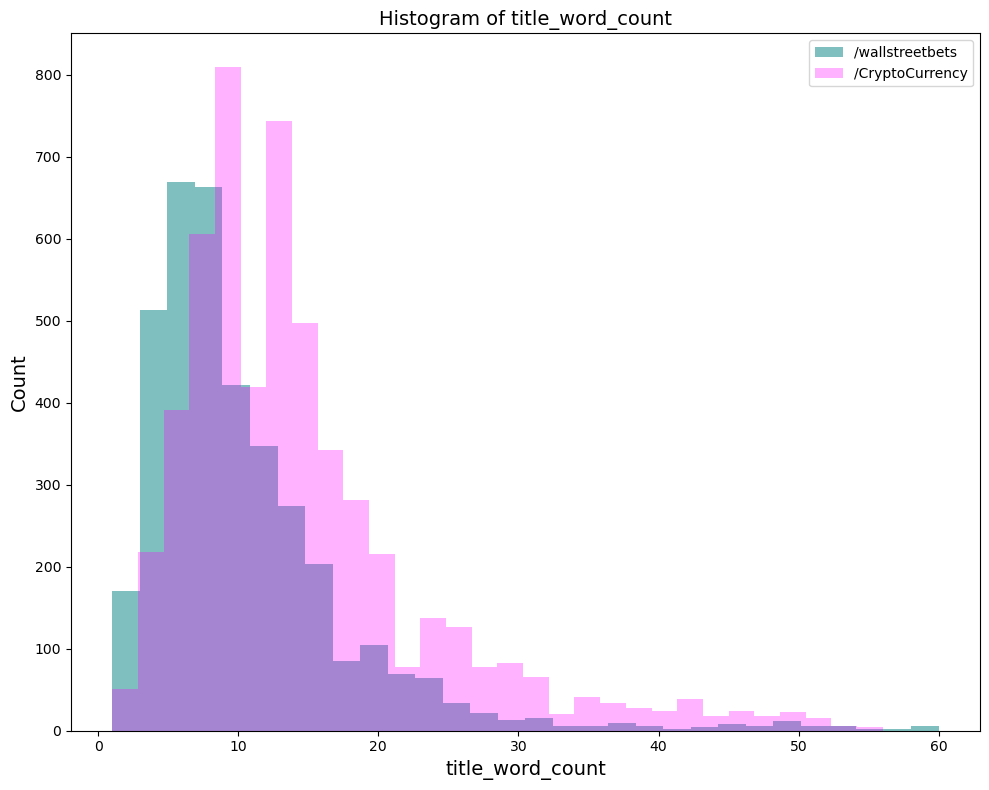

In [72]:
hist_plot(df,'title_word_count')

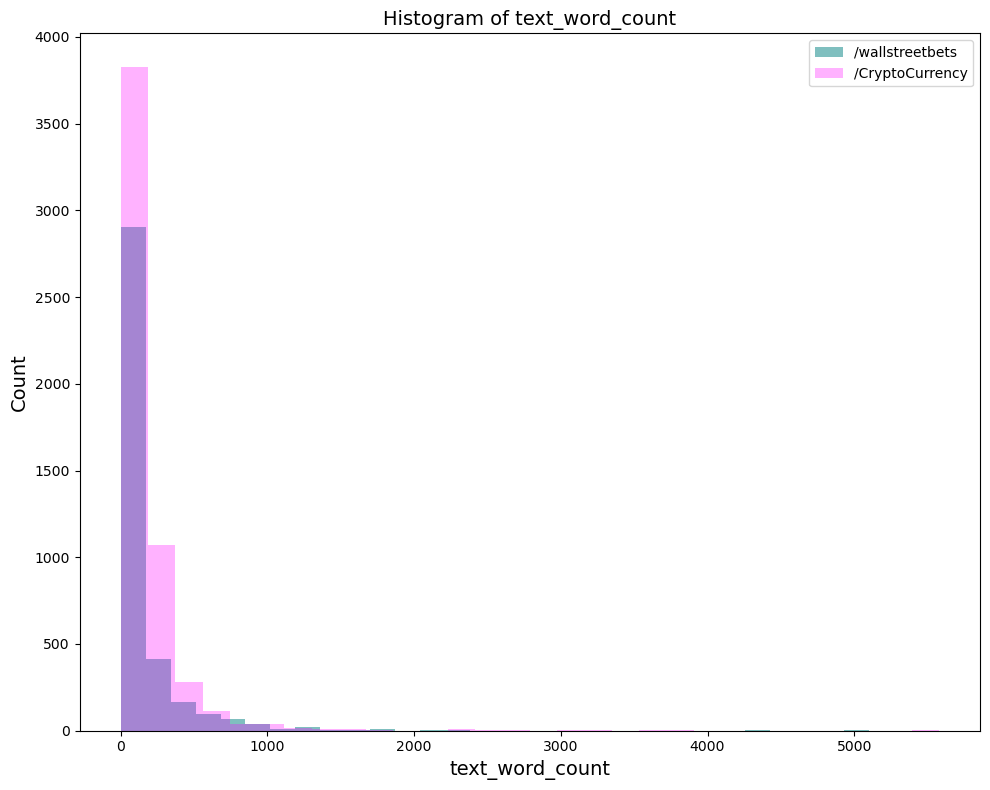

In [73]:
hist_plot(df,'text_word_count')

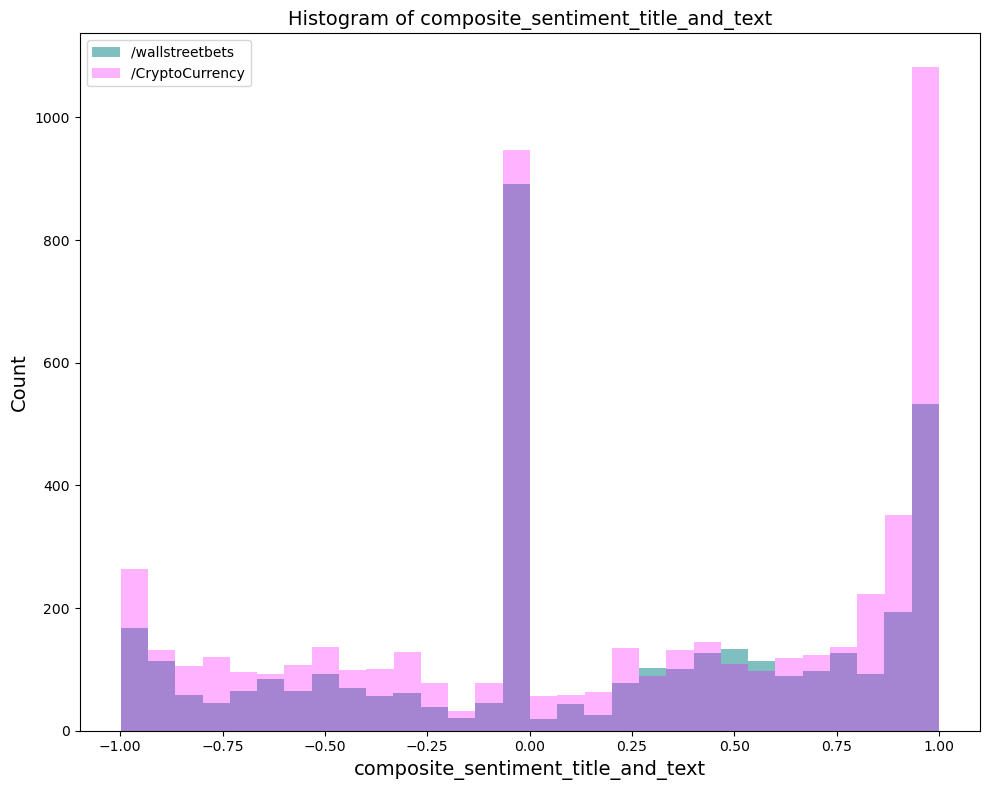

In [74]:
hist_plot(df,'composite_sentiment_title_and_text')


### Modelling

In [24]:
# Set X and y and train-test split dataset 
X = df['title_and_text']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=65)

In [25]:
# initiate my first model pipeline using CountVectorizer and MultinomialNB
pipe = Pipeline([
    ('cvec',CountVectorizer()),
    ('nb', MultinomialNB())
])

In [26]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'nb__force_alpha': 'warn'}

In [27]:
# Parameters to GridSearch over
pipe_param = {
    'cvec__stop_words':['english'],
    'cvec__max_df': [0.5,0.6,0.75],
    'cvec__min_df': [2,3],
    'cvec__ngram_range': [(1,1),(1,3)],
    'cvec__max_features': [8_000,10_000],
    'cvec__strip_accents': [ascii],
    'nb__alpha' : np.linspace(0.001,0.5,5)
}

In [28]:
# Gridsearch over parameters and cross-validate 5 times
# fit the model to the training data
gs = GridSearchCV(pipe,pipe_param,cv=5, n_jobs =4)
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.5, 0.6, 0.75],
                         'cvec__max_features': [8000, 10000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 3)],
                         'cvec__stop_words': ['english'],
                         'cvec__strip_accents': [<built-in function ascii>],
                         'nb__alpha': array([0.001  , 0.12575, 0.2505 , 0.37525, 0.5    ])})

In [29]:
# These were the best parameters for my model
gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'cvec__strip_accents': <function ascii(obj, /)>,
 'nb__alpha': 0.12575}

In [30]:
print(f'Pipeline 1 :: Training Score: {gs.score(X_train,y_train)}')
print(f'Pipeline 1 :: Test Score: {gs.score(X_test,y_test)}')

Pipeline 1 :: Training Score: 0.9553040197358874
Pipeline 1 :: Test Score: 0.9442993907745866


In [31]:
# Predicting y_test from pipe
preds = gs.predict(X_test)
confusion_matrix(y_test,preds)

array([[1324,   21],
       [ 107,  846]], dtype=int64)

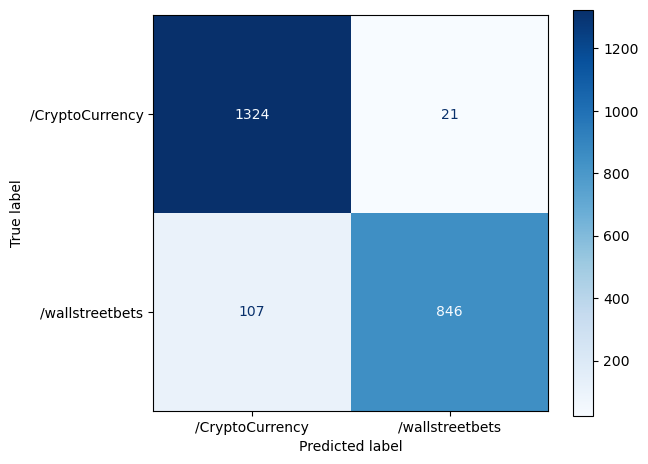

In [67]:
ConfusionMatrixDisplay.from_estimator(estimator = gs,
                                     X = X_test,
                                     y = y_test,
                                     cmap = 'Blues',
                                     display_labels = ['/CryptoCurrency','/wallstreetbets']
                                     );
plt.tight_layout()
plt.savefig('Images/pipe1_confusion_matrix.png',dpi=300)

In [34]:
# initiating second pipeline
pipe2 = Pipeline([
    ('tfdif',TfidfVectorizer()),
    ('svc',SVC())
])

In [35]:
pipe2.get_params()

{'memory': None,
 'steps': [('tfdif', TfidfVectorizer()), ('svc', SVC())],
 'verbose': False,
 'tfdif': TfidfVectorizer(),
 'svc': SVC(),
 'tfdif__analyzer': 'word',
 'tfdif__binary': False,
 'tfdif__decode_error': 'strict',
 'tfdif__dtype': numpy.float64,
 'tfdif__encoding': 'utf-8',
 'tfdif__input': 'content',
 'tfdif__lowercase': True,
 'tfdif__max_df': 1.0,
 'tfdif__max_features': None,
 'tfdif__min_df': 1,
 'tfdif__ngram_range': (1, 1),
 'tfdif__norm': 'l2',
 'tfdif__preprocessor': None,
 'tfdif__smooth_idf': True,
 'tfdif__stop_words': None,
 'tfdif__strip_accents': None,
 'tfdif__sublinear_tf': False,
 'tfdif__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfdif__tokenizer': None,
 'tfdif__use_idf': True,
 'tfdif__vocabulary': None,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probabi

In [39]:
# Parameters to GridSearch over 
pipe2_params = {
    'tfdif__max_df':[0.7,0.8],
    'tfdif__max_features':[1000,2000,4000],
    'tfdif__min_df':[2,5,7],
    'tfdif__stop_words':[None,'english'],
    'svc__C':np.linspace(0.001,10,5),
    'svc__kernel': ['rbf','sigmoid'],
    'svc__random_state':[42],
    
    
    
}

In [40]:
# Gridsearch over parameters and cross-validate 5 times
# fit the model to the training data
gs2 = GridSearchCV(pipe2,pipe2_params,cv=5,n_jobs = 4)
gs2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=4,
             param_grid={'svc__C': array([1.00000e-03, 2.50075e+00, 5.00050e+00, 7.50025e+00, 1.00000e+01]),
                         'svc__kernel': ['rbf', 'sigmoid'],
                         'svc__random_state': [42], 'tfdif__max_df': [0.7, 0.8],
                         'tfdif__max_features': [1000, 2000, 4000],
                         'tfdif__min_df': [2, 5, 7],
                         'tfdif__stop_words': [None, 'english']})

In [41]:
# These were the best parameters for my model
gs2.best_params_

{'svc__C': 2.50075,
 'svc__kernel': 'rbf',
 'svc__random_state': 42,
 'tfdif__max_df': 0.7,
 'tfdif__max_features': 4000,
 'tfdif__min_df': 2,
 'tfdif__stop_words': None}

In [42]:
print(f'Pipeline 2 :: Training Score: {gs2.score(X_train,y_train)}')
print(f'Pipeline 2 :: Test Score: {gs2.score(X_test,y_test)}')

Pipeline 2 :: Training Score: 0.9994195327238427
Pipeline 2 :: Test Score: 0.9843342036553525


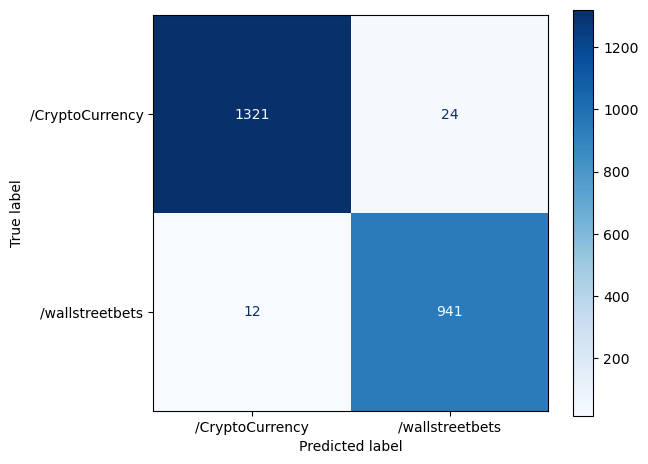

In [68]:
ConfusionMatrixDisplay.from_estimator(estimator = gs2,
                                     X = X_test,
                                     y = y_test,
                                     cmap = 'Blues',
                                     display_labels = ['/CryptoCurrency','/wallstreetbets']
                                     );
plt.tight_layout()
plt.savefig('Images/pipe2_confusion_matrix.png',dpi = 300)